In [1]:
import numpy as np
import matplotlib.pyplot as plt

def DisCo_np(X,Y):
	ajk = np.abs(np.reshape(np.repeat(X,len(X)),[len(X),len(X)]) - np.transpose(X))
	bjk = np.abs(np.reshape(np.repeat(Y,len(Y)),[len(Y),len(Y)]) - np.transpose(Y))

	Ajk = ajk - np.mean(ajk,axis=0)[None, :] - np.mean(ajk,axis=1)[:, None] + np.mean(ajk)
	Bjk = bjk - np.mean(bjk,axis=0)[None, :] - np.mean(bjk,axis=1)[:, None] + np.mean(bjk)

	dcor = np.sum(Ajk*Bjk) / np.sqrt(np.sum(Ajk*Ajk)*np.sum(Bjk*Bjk))
	return dcor


N = 1000
z0 = np.random.normal(0,1,N)
z1 = np.random.normal(0,1,N)
X = z0
xvals = []
yvals = []
for rho in np.linspace(-1,1,20):
	Y = z0*rho + z1*(1.-rho**2)**0.5
	xvals+=[rho]
	yvals+=[DisCo_np(X,Y)]

plt.plot(xvals,yvals)
plt.xlabel("Pearson Correlation")
plt.ylabel("Distance Correlation")
plt.savefig("plots/Pearson.pdf")


Using TensorFlow backend.


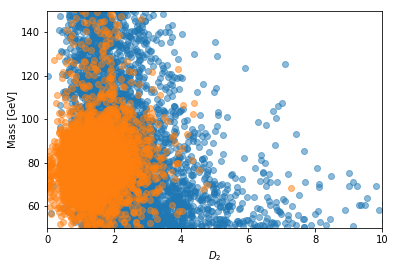

In [2]:
import h5py

f  = h5py.File('../../input/data_10000.h5', 'r')
plt.hist(f['dataset']['table'][:]['m'][f['dataset']['table'][:]['signal']==1],bins=np.linspace(50,150,20),alpha=0.5)
plt.hist(f['dataset']['table'][:]['m'][f['dataset']['table'][:]['signal']==0],bins=np.linspace(50,150,20),alpha=0.5)
plt.savefig("plots/histogram.pdf")

from keras import backend as K
import keras.layers as layers
from keras.models import Model
from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
from sklearn.metrics import roc_curve, roc_auc_score
from keras.losses import binary_crossentropy
import tensorflow as tf

X = f['dataset']['table'][:]['D2'][f['dataset']['table'][:]['signal']==0]
Y = f['dataset']['table'][:]['m'][f['dataset']['table'][:]['signal']==0]
background_x = tuple(zip(X, Y))  
background_y = np.zeros(len(background_x))

X = f['dataset']['table'][:]['D2'][f['dataset']['table'][:]['signal']==1]
Y = f['dataset']['table'][:]['m'][f['dataset']['table'][:]['signal']==1]
signal_x = tuple(zip(X, Y)) 
signal_y = np.ones(len(signal_x))

X = np.concatenate([background_x,signal_x])
Y = np.concatenate([background_y,signal_y])

is_train = np.random.rand(X.shape[0])<0.85

X_train = X[is_train]
Y_train = Y[is_train]

X_val = X[~is_train]
Y_val = Y[~is_train]

plt.scatter(np.array(background_x)[:,0],np.array(background_x)[:,1],alpha=0.5)
plt.scatter(np.array(signal_x)[:,0],np.array(signal_x)[:,1],alpha=0.5)
plt.xlabel(r"$D_{2}$")
plt.ylabel("Mass [GeV]")
plt.xlim([0,10])
plt.ylim([50,150])
plt.savefig("plots/scatter.pdf")
#print(DisCo_np(np.array(background_x)[:,0],np.array(background_x)[:,1]))
#print(DisCo_np(np.array(signal_x)[:,0],np.array(signal_x)[:,1]))


W0215 12:37:11.705158 140514083641152 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0215 12:37:11.744335 140514083641152 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0215 12:37:11.776460 140514083641152 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0215 12:37:11.812402 140514083641152 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 16,897
Trainable params: 16,897
Non-trainable params: 0
_________________________________________________________________
Train 

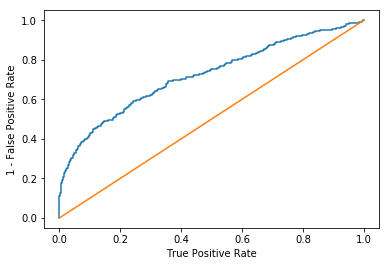

In [3]:
Nepochs = 5

def redacted_set(x):
	#Returns everything except the last element.  This is the decorrelation target ("Mass")
	return x[:,0:-1]

#This network is rather generic and simple.  You can swap it out with something more 
#complicated.  Just need to use the custom first layer to separate out the mass if 
#you don't want it to be used directly in the training (aside from the decorrelation penality).
model0 = Sequential()
model0.add(Lambda(redacted_set,input_shape =(2,)))
model0.add(Dense(128, activation='relu')) 
model0.add(layers.Dropout(0.25))
model0.add(Dense(128, activation='relu'))
model0.add(layers.Dropout(0.25))
model0.add(Dense(1, activation='sigmoid'))
model0.summary()
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_model = model0.fit(X_train, Y_train, epochs=Nepochs, batch_size=128,validation_data=(X_val, Y_val))
preds = model0.predict(X_val)
fpr, tpr, _ = roc_curve(Y_val, 1-preds)

plt.plot(tpr,fpr)
plt.plot([0,1],[0,1])
plt.xlabel("True Positive Rate")
plt.ylabel("1 - False Positive Rate")
plt.savefig("plots/ROC_pre.pdf")

Tensor("loss_2/dense_9_loss/Select:0", shape=(?, 1), dtype=float32)
Train on 8541 samples, validate on 1459 samples
Epoch 1/25
8541/8541 [==============================] - 1s 150us/step - loss: 2.5671 - acc: 0.5016 - val_loss: 9.7463 - val_acc: 0.5045
Epoch 2/25
8541/8541 [==============================] - 1s 67us/step - loss: 1.7918 - acc: 0.5115 - val_loss: 8.4159 - val_acc: 0.4955
Epoch 3/25
8541/8541 [==============================] - 1s 68us/step - loss: 1.8569 - acc: 0.5046 - val_loss: 6.4961 - val_acc: 0.5463
Epoch 4/25
8541/8541 [==============================] - 1s 64us/step - loss: 1.6847 - acc: 0.5133 - val_loss: 6.0898 - val_acc: 0.5805
Epoch 5/25
8541/8541 [==============================] - 1s 69us/step - loss: 1.6793 - acc: 0.5296 - val_loss: 1.4294 - val_acc: 0.5093
Epoch 6/25
8541/8541 [==============================] - 1s 69us/step - loss: 1.5673 - acc: 0.5251 - val_loss: 1.6520 - val_acc: 0.4955
Epoch 7/25
8541/8541 [==============================] - 1s 70us/step - lo

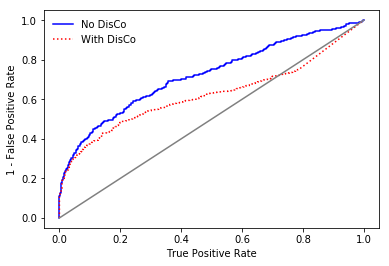

In [6]:
def DisCo(y_true, y_pred, x_in, alpha = 0.):
	#alpha determines the amount of decorrelation; 0 means no decorrelation.
	#Note that the decorrelating feature is also used for learning.
	    
	X_in = tf.gather(x_in, [1], axis=1) #decorrelate with the second element of the input (=mass)
	Y_in = y_pred

	#Only require decorrelation for the background.
	mymaskX = tf.where(Y_in<1,K.ones_like(X_in),K.zeros_like(X_in))
	mymaskY = tf.where(Y_in<1,K.ones_like(Y_in),K.zeros_like(Y_in))
	print mymaskX
	#X = tf.boolean_mask(X_in, mymaskX)
	#Y = tf.boolean_mask(Y_in, mymaskY)
	X = X_in
	Y = Y_in
	    
	LX = K.shape(X)[0]
	LY = K.shape(Y)[0]
			    
	X=K.reshape(X,shape=(LX,1))
	Y=K.reshape(Y,shape=(LY,1))    
	    
	ajk = K.abs(K.reshape(K.repeat(X,LX),shape=(LX,LX)) - K.transpose(X))
	bjk = K.abs(K.reshape(K.repeat(Y,LY),shape=(LY,LY)) - K.transpose(Y))

	Ajk = ajk - K.mean(ajk,axis=0)[None, :] - K.mean(ajk,axis=1)[:, None] + K.mean(ajk)
	Bjk = bjk - K.mean(bjk,axis=0)[None, :] - K.mean(bjk,axis=1)[:, None] + K.mean(bjk)

	dcor = K.sum(Ajk*Bjk) / K.sqrt(K.sum(Ajk*Ajk)*K.sum(Bjk*Bjk))    
	    
	return binary_crossentropy(y_true,y_pred) + alpha*dcor

model = Sequential()
model.add(Dense(128, activation='relu',input_shape =(2,))) 
model.add(layers.Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=lambda y_true, y_pred: DisCo(y_true, y_pred, model.input, alpha = 10.), optimizer='adam', metrics=['accuracy'])
hist_model = model.fit(X_train, Y_train, epochs=5*Nepochs, batch_size=128,validation_data=(X_val, Y_val))
preds = model.predict(X_val)
fpr0, tpr0, _ = roc_curve(Y_val, 1-preds)

plt.plot(tpr,fpr,color='blue',label="No DisCo")
plt.plot(tpr0,fpr0,linestyle=":",color='red',label="With DisCo")
plt.plot([0,1],[0,1],color='gray')
plt.xlabel("True Positive Rate")
plt.ylabel("1 - False Positive Rate")
plt.legend(frameon=False)
plt.savefig("plots/ROC.pdf")

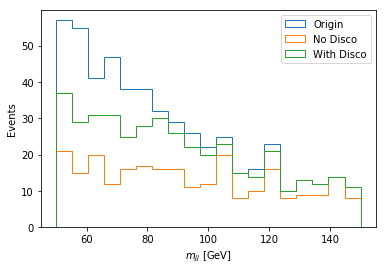

In [9]:
#print Y_val
x = X_val[Y_val==0]
#print x
predicts0 = model0.predict(x)
predicts = model.predict(x)
#print predicts0
#print predicts
#print x[predicts[:,0]<0.6,1]
plt.hist(x[(predicts0[:,0]>-1) & (predicts0[:,0]<1),1],bins=np.linspace(50,150,20),histtype='step',label="Origin")
plt.hist(x[(predicts0[:,0]>0.4) & (predicts0[:,0]<1),1],bins=np.linspace(50,150,20),histtype='step',label="No Disco")
plt.hist(x[(predicts[:,0]>0.4) & (predicts[:,0]<1),1],bins=np.linspace(50,150,20),histtype='step',label="With Disco")
#plt.hist(x[(predicts0[:,0]>0.5) & (predicts0[:,0]<1),1],bins=np.linspace(50,150,20),alpha=0.5)
#plt.hist(x[(predicts[:,0]>0.5) & (predicts[:,0]<1),1],bins=np.linspace(50,150,20),alpha=0.5)
plt.xlabel("$m_{jj}$ [GeV]")
plt.ylabel("Events")
plt.legend()